<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.855 · Modelos avanzados de minería de datos</p>
<p style="margin: 0; text-align:right;">2022-2 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

# PEC 2: Métodos no supervisados

A lo largo de esta práctica veremos como aplicar distintas técnicas no supervisadas, así como algunas de sus aplicaciones reales:

 - **[Clustering con distintas estrategias](#ej1)**: k-means y regla del codo, basadas en densidad y jerárquicas.
 - **[Aplicación para comprimir imágenes](#ej2)**: clustering y análisis.
 - **[Aplicación de reducción de dimensionalidad para resolver un problema de optimización](#ej3)**: t-SNE.

<u>Consideraciones generales</u>: 

- La solución planteada no puede utilizar métodos, funciones o parámetros declarados **_deprecated_** en futuras versiones, a excepción de que se indique explícitamente.
- Esta PEC debe realizarse de forma **estrictamente individual**. Cualquier indicio de copia será penalizado con un suspenso (D) para todas las partes implicadas y la posible evaluación negativa de la asignatura de forma íntegra.
- Es necesario que el estudiante indique **todas las fuentes** que ha utilizado para la realización de la PEC. De no ser así, se considerará que el estudiante ha cometido plagio, siendo penalizado con un suspenso (D) y la posible evaluación negativa de la asignatura de forma íntegra.

<u>Formato de la entrega</u>:

- Algunos ejercicios pueden suponer varios minutos de ejecución, por lo que la entrega debe hacerse en **formato notebook** y en **formato html**, donde se vea el código, los resultados y comentarios de cada ejercicio. Se puede exportar el notebook a HTML desde el menú File $\to$ Download as $\to$ HTML.
- Existe un tipo de celda especial para albergar texto. Este tipo de celda os será muy útil para responder a las diferentes preguntas teóricas planteadas a lo largo de la actividad. Para cambiar el tipo de celda a este tipo, en el menú: Cell $\to$ Cell Type $\to$ Markdown.

<div class="alert alert-block alert-info">
<strong>Nombre y apellidos: Lukaz Martin Doehne</strong>
</div>

Iniciamos la actividad con la carga de las siguientes librerías:

In [1]:
import random

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn import cluster        # Algoritmos de clustering.
from sklearn import datasets       # Crear datasets.

%matplotlib inline

<a id="ej1"></a>

## 1. Métodos de *clustering* (5 puntos)

Este ejercicio trata de explorar distintas técnicas de agrupamiento, ajustándolas a distintos conjuntos de datos.

El objetivo es doble: 
- entender la influencia de los parámetros en su comportamiento, 
- y conocer sus limitaciones en la búsqueda de estructuras de datos.

### Generación de los conjuntos de datos

In [2]:
X_blobs, y_blobs = datasets.make_blobs(n_samples=1000, n_features=2, centers=4, cluster_std=1.6, random_state=42)
X_moons, y_moons = datasets.make_moons(n_samples=1000, noise=.07, random_state=42)
X_circles, y_circles = datasets.make_circles(n_samples=1000, factor=.5, noise=.05, random_state=42)

Cada dataset tiene 2 variables: una variable *X* que contiene 2 features (columnas) y tantas filas como muestras. Y una variable *y* que alberga las etiquetas que identifican cada cluster.

A lo largo del ejercicio no se usará la variable *y* (sólo con el objetivo de visualizar). El objetivo es encontrar las estructuras descritas por las variables *y* a través de los distintos modelos de *clustering* conseguir.

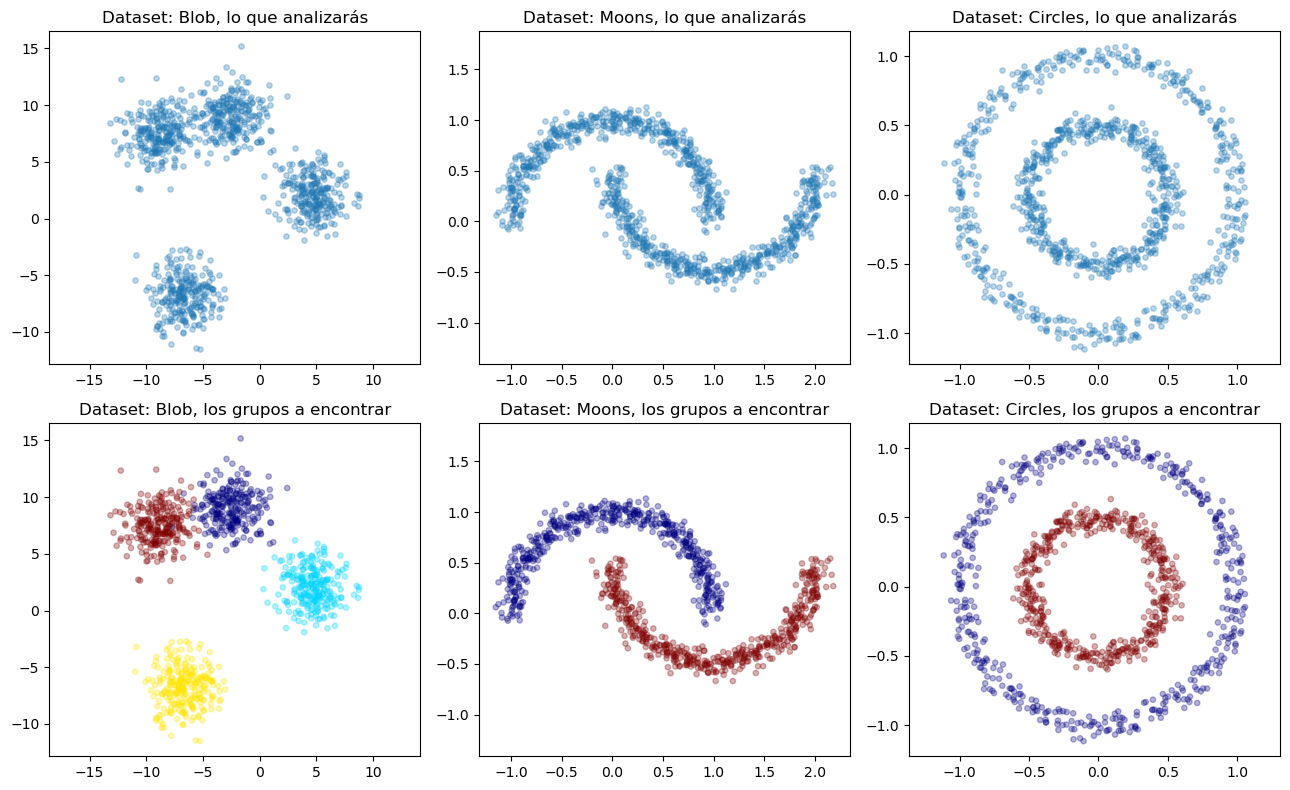

In [3]:
fig, axis = plt.subplots(2, 3, figsize=(13, 8))
for i, (X, y, ax, name) in enumerate(zip([X_blobs, X_moons, X_circles] * 2,
                                         [None] * 3 + [y_blobs, y_moons, y_circles],
                                         axis.reshape(-1),
                                         ['Blob', 'Moons', 'Circles'] * 2)):
    ax.set_title('Dataset: {}, '.format(name) + ('lo que analizarás' if i < 3 else 'los grupos a encontrar'))
    ax.scatter(X[:,0], X[:,1], s=15, c=y, alpha=.3, cmap='jet')
    ax.axis('equal')
plt.tight_layout()

### 1 a. K-means

En este apartado se pide probar el algoritmo *k-means* sobre los tres datasets presentados anteriormente ajustando con los parámetros adecuados y analizar sus resultados.

In [4]:
X, y = X_blobs, y_blobs

Para estimar el número de clusters a detectar por *k-means*. Una técnica para estimar $k$ es, como se explica en la teoría:
> Los criterios anteriores (minimización de distancias intra grupo o maximización de distancias inter grupo) pueden usarse para establecer un valor adecuado para el parámetro k. Valores k para los que ya no se consiguen mejoras significativas en la homogeneidad interna de los segmentos o la heterogeneidad entre segmentos distintos, deberían descartarse.

Lo que popularmente se conocer como *regla del codo*.

Primero es necesario calcular la suma de los errores cuadráticos ([*SSE*](https://bl.ocks.org/rpgove/0060ff3b656618e9136b)) que consiste en la suma de todos los errores (distancia de cada punto a su centroide asignado) al cuadrado.

$$SSE = \sum_{i=1}^{K} \sum_{x \in C_i} euclidean(x, c_i)^2$$

Donde $K$ es el número de clusters a buscar por *k-means*, $x \in C_i$ son los puntos que pertenecen a i-ésimo cluster, $c_i$ es el centroide del cluster $C_i$ (al que pertenece el punto $x$), y $euclidean$ es la [distancia euclídea](https://en.wikipedia.org/wiki/Euclidean_distance).

Este procedimiento realizado para cada posible valor $k$, resulta en una función monótona decreciente, donde el eje $x$ representa los distintos valores de $k$, y el eje $y$ el $SSE$. Intuitivamente se podrá observar un significativo descenso del error, que indicará el valor idóneo de $k$.

**Se pide realizar la representación gráfica de la regla del codo junto a su interpretación, utilizando la librería ```matplotlib``` y la implementación en scikit-learn de [*k-means*](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).**

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> cálculo y visualización de la regla del codo en el dataset Blobs.
</div>

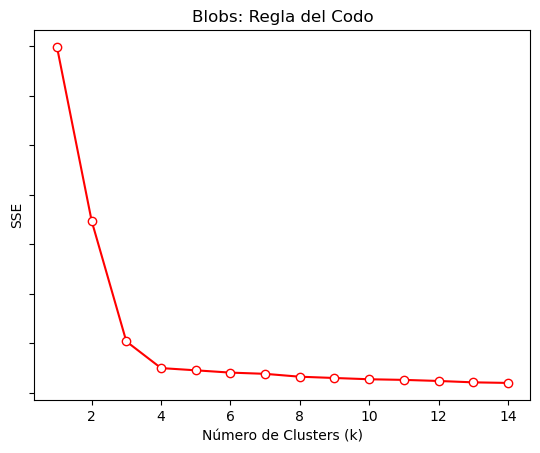

In [8]:
# Creamos una función para posterior uso
def elbow_rule(X, name):
    #Elegimos el rango de valores de k que queremos comprobar
    k_range = range(1,15)

    # Guardamos la suma de errores (distancia) cuadráticos para cada k
    # El atributo inertia_ nos devuelve la suma cuadrática de la distancia de los blobs al centro del cluster más cercano.
    # El parámetro random_state nos permite hacer el experimento determinista. Cualquier integer es válido.
    sse = []
    kmeans_tries = []
    for k in k_range:
        kmeans = cluster.KMeans(n_clusters=k, n_init='auto', random_state=42)
        kmeans.fit(X)
        sse.append(kmeans.inertia_)
        kmeans_tries.append(kmeans)

    # Visualización de la regla del codo
    plt.plot(k_range, sse, 'ro-', markerfacecolor='white', markeredgecolor='red')
    plt.xlabel('Número de Clusters (k)')
    plt.ylabel('SSE')
    plt.tick_params(labelleft=False)
    plt.title(name + ': Regla del Codo')
    plt.show()
    return kmeans_tries
kmeans_tries = elbow_rule(X,"Blobs")

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿qué se interpreta en la gráfica?, ¿Cómo podría mejorarse la elección de $k$?
</div>

La gráfica muestra la evolución de la suma de los errores cuadráticos (SSE) a medida que aumenta el número de clústers. En concreto, podemos observar *la regla del codo*, que indica que SSE dismunye significativamente hasta llegar al "codo". En este caso, **el "codo" se encuentra en k=4**, siendo el número óptimo de clústers para el dataset Blobs.


Realmente la elección de k es óptima para este dataset, como se puede observar en el siguiente gráfico que muestra cómo se detectan correctamente los 4 clusters. Por lo tanto, no se podría mejorar la elección de k.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> cálculo y visualización de los grupos en el dataset Blobs.
</div>

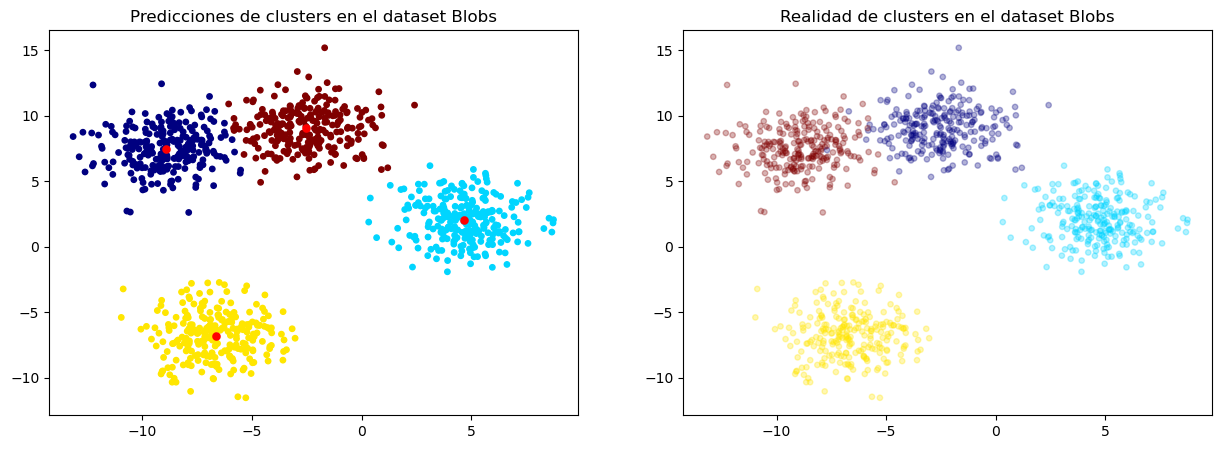

In [14]:
# Creamos una función para posterior uso
def visualization_kmeans(X,y,predictor, title):
    # Visualización de los grupos resultantes predichos
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.scatter(X[:, 0], X[:, 1], s=15, c=predictor.fit_predict(X), cmap='jet')
    plt.title("Predicciones de clusters en el dataset " + title)
    centroides = predictor.cluster_centers_
    # Añadimos los centroides al plot
    plt.scatter(centroides[:, 0], centroides[:, 1], marker='o', s=10, linewidths=3, color='red')
    
    # Dataset original
    plt.subplot(122)
    plt.scatter(X[:,0], X[:,1], s=15, c=y, alpha=.3, cmap='jet')
    plt.title("Realidad de clusters en el dataset " + title)
    plt.show()
# Utilizamos el intento en la posición 3 -> k=4
visualization_kmeans(X,y,kmeans_tries[3], "Blobs")

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado. 
</div>

Se han obtenido 4 clústeres diferentes a partir de la predicción.La agrupación se realiza asignando cada Blob al clúster cuyo centroide está más cercano. Los centroides están marcados en rojo.

En este dataset, los 4 grupos están claramente definidos y son separables de manera lineal, por lo que el resultado obtenido es correcto y predecible debido a la naturaleza de los datos. Sin embargo, **si los grupos tienen formas no lineales o están muy próximos entre sí, kmeans puede no detectar correctamente los clústeres, ya que el centroide no se encuentra en la media de los puntos del grupo.**

In [16]:
X, y = X_moons, y_moons

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> cálculo y visualización de la regla del codo en el dataset Moons.
</div>

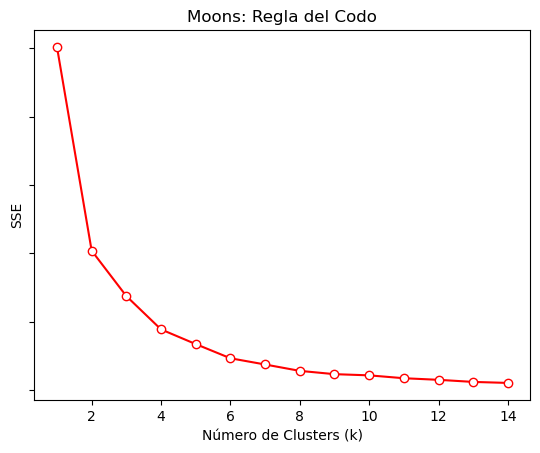

In [17]:
kmeans_tries=elbow_rule(X, "Moons")

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿qué se interpreta en la gráfica?, ¿cómo podría mejorarse la elección de $k$?.  
</div>

En la gráfica se puede ver cómo evoluciona la suma de los errores cuadráticos (SSE) en función del número de clústers.

A diferencia del conjunto de datos anterior, en esta gráfica la regla del codo no es tan evidente. El valor SSE disminuye de forma más suave a partir de los 2 clústeres, por lo que la elección sería k=2. Sin embargo, otras opciones podrían ser k=3 o k=4.

Existen otras formas de elegir el valor de k, como por ejemplo:

    · permitir que el número k se modifique durante la ejecución.

    · utilizar otras métricas de evaluación (RSS).
    
    · el método de la silueta, que calcula la similitud entre un punto y su clúster en comparación con otros clústers.

En realidad, el problema radica en la forma en que se agrupan los datos en este conjunto. Dado que **los datos están más cerca de otro grupo que de su centroide**, y además, su centroide no se encuentra en el centro del grupo, KMeans no detecta correctamente los clústers.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> cálculo y visualización de los grupos en el dataset Moons.
</div>

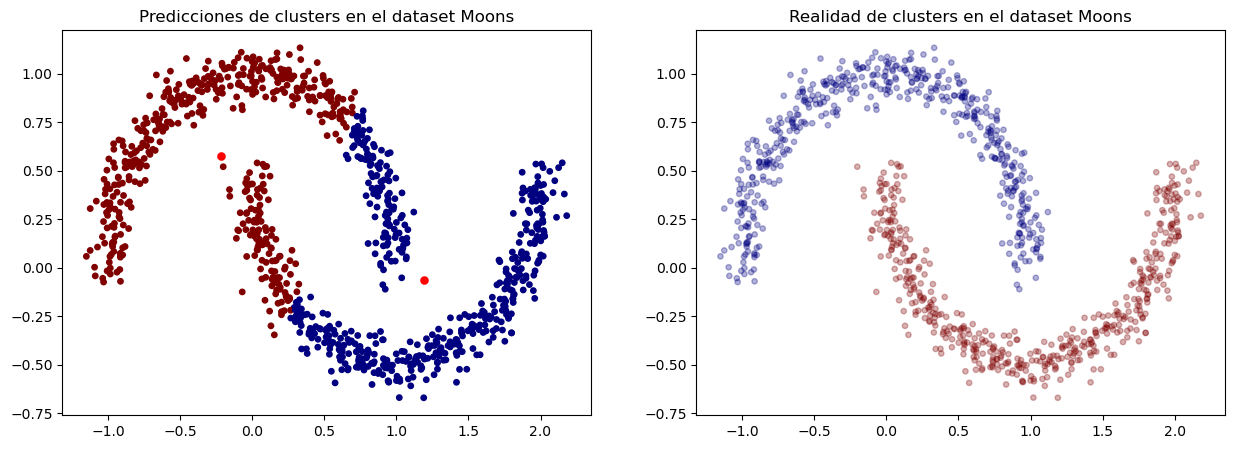

In [18]:
# Utilizamos el intento en la posición 1 -> k=2
visualization_kmeans(X,y,kmeans_tries[1], "Moons")

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

En este caso, podemos observar que el método Kmeans no ha predicho correctamente las agrupaciones. Los centroides explican el resultado.

Este problema se debe a la forma de los datos, ya que **algunos puntos están más cerca de otro grupo que de su propio centroide**.

In [19]:
X, y = X_circles, y_circles

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> cálculo y visualización de la regla del codo en el dataset Circles.
</div>

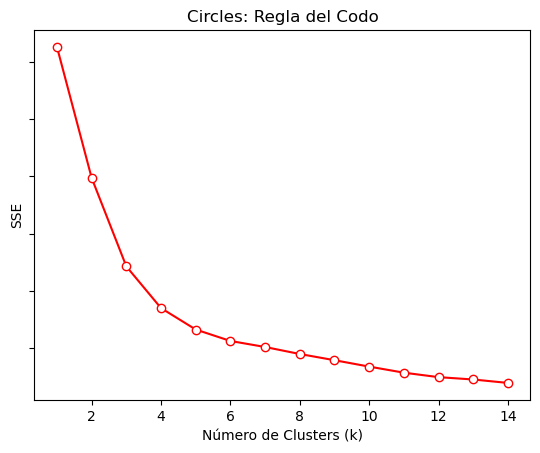

In [20]:
kmeans_tries=elbow_rule(X, "Circles")

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué se interpreta en la gráfica?, ¿cómo podría mejorarse la elección de $k$?.  
</div>

En este caso, al igual que en la gráfica anterior, **resulta difícil determinar el valor óptimo de k utilizando la regla del codo**. Aunque el valor SSE disminuye de forma suave a partir de los 3 clústeres, la elección podrías ser k=3,k=4 o k=5.

Todas las predicciones de k serían erróneas.La razón detrás de la imprecisión es que los grupos están muy cerca unos de otros y no pueden ser separados adecuadamente utilizando centroides.

Aunque existen otras formas de elegir el valor de k, como permitir que k se modifique durante la ejecución, utilizar otras métricas de evaluación como RSS o el método de la silueta, la predicción final seguiría siendo incorrecta debido a la naturaleza de los datos.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> cálculo y visualización de los grupos en el dataset Circles.
</div>

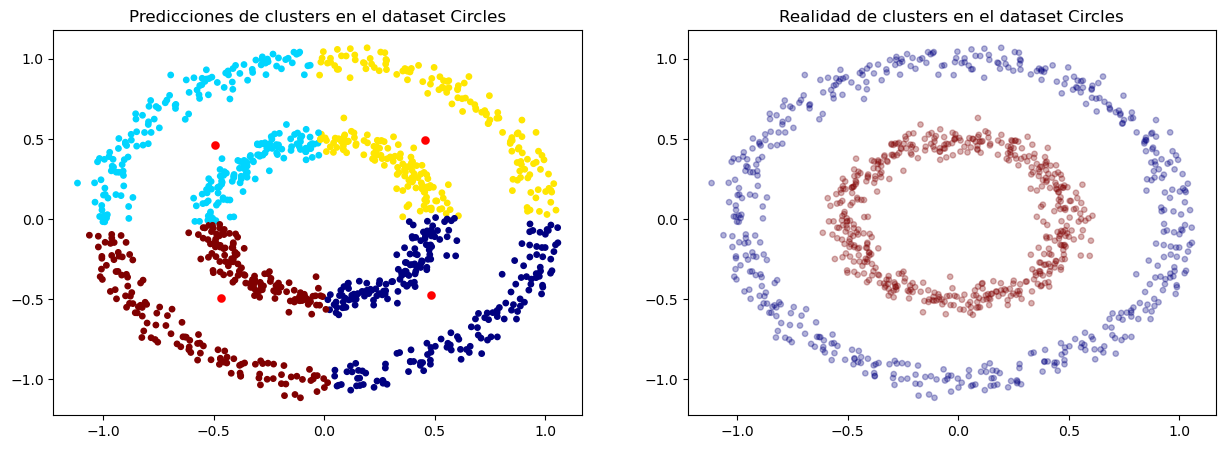

In [21]:
# Utilizamos el intento en la posición 3 -> k=4
visualization_kmeans(X,y,kmeans_tries[3], "Circles")

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

En este caso, podemos observar que el método Kmeans no ha predicho de forma correcta las agrupaciones, ni el número de clústeres. La forma no-lineal de los datos hace que sea difícil predecir el número de clústeres y, aunque se puedan identificar dos agrupaciones, Kmeans no las detectaría correctamente.

Esto es debido a que **es imposible posicionar 2 centroides de tal manera que se detecten los 2 clústeres correctamente**.

### 1 b. Algoritmos basados en densidad: DBSCAN

En este apartado se pide aplicar clustering por densidad como [DBSCAN](https://en.wikipedia.org/wiki/DBSCAN) a los datasets anteriores para detectar los dos grupos subyacentes.

Ésta es una visualización intuitiva de su funcionamiento: https://www.youtube.com/watch?v=RDZUdRSDOok

In [22]:
X, y = X_blobs, y_blobs

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> prueba la implementación de <a href="http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html">DBSCAN en scikit-learn</a> jugando con los parámetros <i>eps</i> y <i>min_samples</i> para encontrar los grupos (y <i>outliers</i>) del dataset Blobs.
</div>

In [23]:
# Creo una función para posterior uso
def dbscan_finetuning(X):
    # Por defecto el valor eps es 0.5 (distancia entre datos)
    # [0.1, 0.2, 0.3...1]
    eps = [round(x*0.1, 1) for x in range(1, 11)]

    # Por defecto min_samples es 5 (número de vecinos mínimos para ser core-point)
    # [5, 10, 15, 20]
    min_samples = [x for x in range(5,25,5)]

    results = []
    for ep in eps:
        for min_sample in min_samples:
            dbscan = cluster.DBSCAN(eps=ep, min_samples=min_sample)
            dbscan.fit(X)

            # Noisy samples o outliers se les da el valor -1
            n_outliers = list(dbscan.labels_).count(-1)

            # Cada valor único de labels_ diferente a -1 será un cluster
            n_clusters = len(set(dbscan.labels_))
            if n_outliers > 0:
                n_clusters -= 1 

            results.append([ep, min_sample, n_clusters, n_outliers])

    return pd.DataFrame(results, columns=['Eps', 'Min_Samples', 'Clusters', 'Outliers'])

In [24]:
output = dbscan_finetuning(X)
print("Blobs resultados con menos outliers:")
display(output.sort_values(by=['Outliers']).head())
print("\nBlobs resultados con menor Eps:")
display(output.head())
print("\nBlobs resultados con diferente min_sample:")
min_samples_analysis=[]
for i in [5,10,15,20]:
    min_samples_analysis.append([len(output[(output['Min_Samples'] == i) & (output['Clusters'] == 4)])])
display(pd.DataFrame(min_samples_analysis, index=[5,10,15,20], columns=["Predicción de 4 clústeres"]).T)

Blobs resultados con menos outliers:


Eps  Min_Samples  Clusters  Outliers
36  1.0            5         4        26
32  0.9            5         5        41
28  0.8            5         5        54
37  1.0           10         3        63
24  0.7            5         6        85


Blobs resultados con menor Eps:


Eps  Min_Samples  Clusters  Outliers
0  0.1            5         0      1000
1  0.1           10         0      1000
2  0.1           15         0      1000
3  0.1           20         0      1000
4  0.2            5        23       859


Blobs resultados con diferente min_sample:


5   10  15  20
Predicción de 4 clústeres   1   1   4   4

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

Observamos que valor con un Eps muy bajo (0.1), el algoritmo no encuentra vecinos de los datos y asigna todo los valores como ruido (0 clusters). Como es de esperar valores más altos de Eps proporcionan menos ruido, aun así el dataset está disperso.

En cuanto al parámetro min_samples, los valores 10, 15 o 20 han demostrado ser más consistentes. Al comparar los resultados, se observa que el uso de 15 o 20 vecinos ha llevado a una asignación más frecuente de 4 clústeres. Sin embargo, esta evaluación solo es posible debido al conocimiento previo de las etiquetas correctas.

Por lo que respecta al ruido, la mejor predicción es con *eps de 1 y min_samples de 5*, que a su vez detecta correctamente 4 clústeres. Pero este resultado es erroneo como vemos en el siguiente plot. 

En general los plots con min_samples=20 han detectado los clústers de manera más correcta.

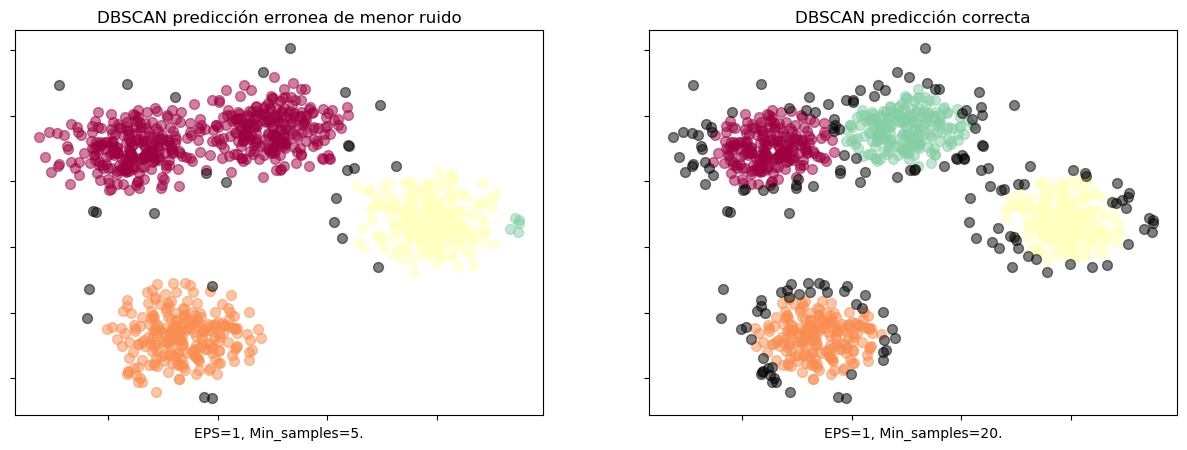

In [48]:
plt.figure(figsize=(15,5))
plt.subplot(121)
dbscan = cluster.DBSCAN(eps=1, min_samples=5)
dbscan.fit(X)
# Obtener las etiquetas de cada punto
labels = dbscan.labels_

# Crear un scatter plot donde cada color representa una etiqueta distinta
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Pintar los puntos asignados a la etiqueta -1 en negro
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    xy = X[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], s=50, c=[col], marker='o', alpha=0.5)
plt.title('DBSCAN predicción erronea de menor ruido')
plt.xlabel('EPS=1, Min_samples=5.')
plt.tick_params(labelleft=False)
plt.tick_params(labelbottom=False)

# Correcto
plt.subplot(122)
dbscan = cluster.DBSCAN(eps=1, min_samples=20)
dbscan.fit(X)
# Obtener las etiquetas de cada punto
labels = dbscan.labels_

# Crear un scatter plot donde cada color representa una etiqueta distinta
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Pintar los puntos asignados a la etiqueta -1 en negro
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    xy = X[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], s=50, c=[col], marker='o', alpha=0.5)
plt.title('DBSCAN predicción correcta')
plt.xlabel('EPS=1, Min_samples=20.')
plt.tick_params(labelleft=False)
plt.tick_params(labelbottom=False)
plt.show()


In [49]:
X, y = X_moons, y_moons

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> prueba la implementación de DBSCAN jugando con los parámetros <i>eps</i> y <i>min_samples</i> para encontrar los grupos (y <i>outliers</i>) del dataset Moons.
</div>

In [50]:
output = dbscan_finetuning(X)
print("Moons primeros resultados:")
display(output.head(10))

Moons primeros resultados:


Eps  Min_Samples  Clusters  Outliers
0  0.1            5         2         7
1  0.1           10         2        19
2  0.1           15         2        40
3  0.1           20         4        70
4  0.2            5         2         0
5  0.2           10         2         0
6  0.2           15         2         0
7  0.2           20         2         0
8  0.3            5         1         0
9  0.3           10         1         0

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

La diferencia con respecto al conjunto de datos anterior es que en este caso hay muy pocos valores atípicos (outliers) y estos desaparecen al usar un valor de eps mayor o igual a 0.2. Esto sugiere que los datos están bastante conectados entre sí.

En cuanto al número de clústeres, principalmente se detectan 1 o 2. El punto de cambio se encuentra en un valor de eps de 0.2. A partir de este valor, todas las predicciones indican la presencia de 1 único clúster, ya que el radio de distancia es demasiado grande y engloba todos los datos en el mismo clúster.

Cómo podemos observar, la primera predicción con eps=0.2 es correcta.

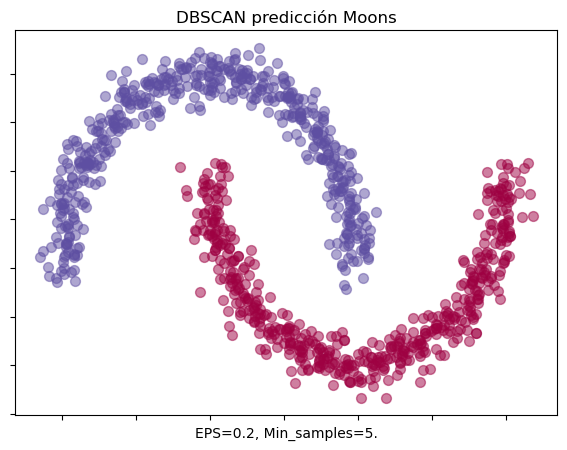

In [52]:
plt.figure(figsize=(7,5))
dbscan = cluster.DBSCAN(eps=0.2, min_samples=5)
dbscan.fit(X)
# Obtener las etiquetas de cada punto
labels = dbscan.labels_

# Crear un scatter plot donde cada color representa una etiqueta distinta
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Pintar los puntos asignados a la etiqueta -1 en negro
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    xy = X[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], s=50, c=[col], marker='o', alpha=0.5)
plt.title('DBSCAN predicción Moons')
plt.xlabel('EPS=0.2, Min_samples=5.')
plt.tick_params(labelleft=False)
plt.tick_params(labelbottom=False)
plt.show()


In [55]:
X, y = X_circles, y_circles

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> prueba la implementación de DBScan jugando con los parámetros <i>eps</i> y <i>min_samples</i> para encontrar los grupos (y <i>outliers</i>) del dataset Circles.
</div>

In [56]:
output = dbscan_finetuning(X)
print("Circles primeros resultados:")
display(output.head(10))

Circles primeros resultados:


Eps  Min_Samples  Clusters  Outliers
0  0.1            5         2         0
1  0.1           10         2         5
2  0.1           15        19       112
3  0.1           20         1       503
4  0.2            5         2         0
5  0.2           10         2         0
6  0.2           15         2         0
7  0.2           20         2         0
8  0.3            5         1         0
9  0.3           10         1         0

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

Similar al conjunto de datos anterior, al utilizar valores mayores a Eps=0.2, el algoritmo detecta un solo clúster, ya que el radio de distancia es demasiado grande y engloba todos los datos en un único cluster.

Sin embargo, para los valores Eps=0.1 y Min_Samples=15,20, el algoritmo detecta muchos outliers debido a que se buscan demasiados vecinos para un dato.

Después de analizar los resultados, parece que el mejor valor de Eps es 0.2. En la primera predicción con este valor, se obtiene una predicción correcta.

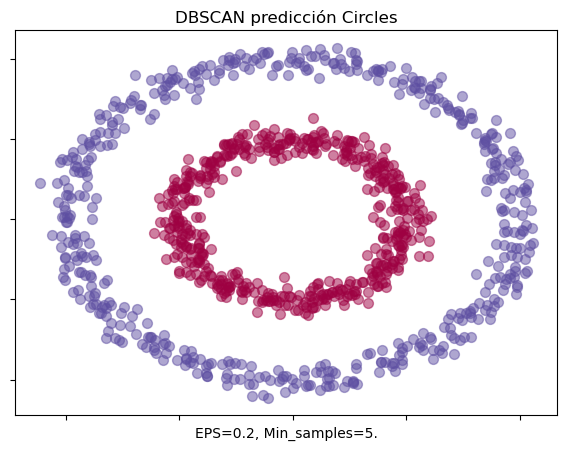

In [58]:
plt.figure(figsize=(7,5))
dbscan = cluster.DBSCAN(eps=0.2, min_samples=5)
dbscan.fit(X)
# Obtener las etiquetas de cada punto
labels = dbscan.labels_

# Crear un scatter plot donde cada color representa una etiqueta distinta
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Pintar los puntos asignados a la etiqueta -1 en negro
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    xy = X[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], s=50, c=[col], marker='o', alpha=0.5)
plt.title('DBSCAN predicción Circles')
plt.xlabel('EPS=0.2, Min_samples=5.')
plt.tick_params(labelleft=False)
plt.tick_params(labelbottom=False)
plt.show()


### 1 c. Algoritmos jerárquicos

En este apartado se pide visualizar mediante un [dendrograma](https://en.wikipedia.org/wiki/Dendrogram) la construcción progresiva de los grupos mediante un algoritmo jerárquico aglomerativo (estrategia *bottom-up*). Con ello se pretende encontrar un método gráfico para entender el comportamiento del algoritmo y encontrar los *clusters* deseados en cada dataset.

In [67]:
X, y = X_blobs, y_blobs

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> prueba la implementación de <a href="https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html">clustering jerárquico de scipy</a> probando distintos <a href="https://en.wikipedia.org/wiki/Hierarchical_clustering#Linkage_criteria">criterios de enlace o <i>linkage</i></a> permitiendo identificar los clusters subyacentes (mostrando su resultado) y su dendrograma para el dataset Blobs.<br>
Puedes importar las librerías necesarias para ello.
</div>

In [60]:
linkages = ['single','complete','average','centroid','median','ward']

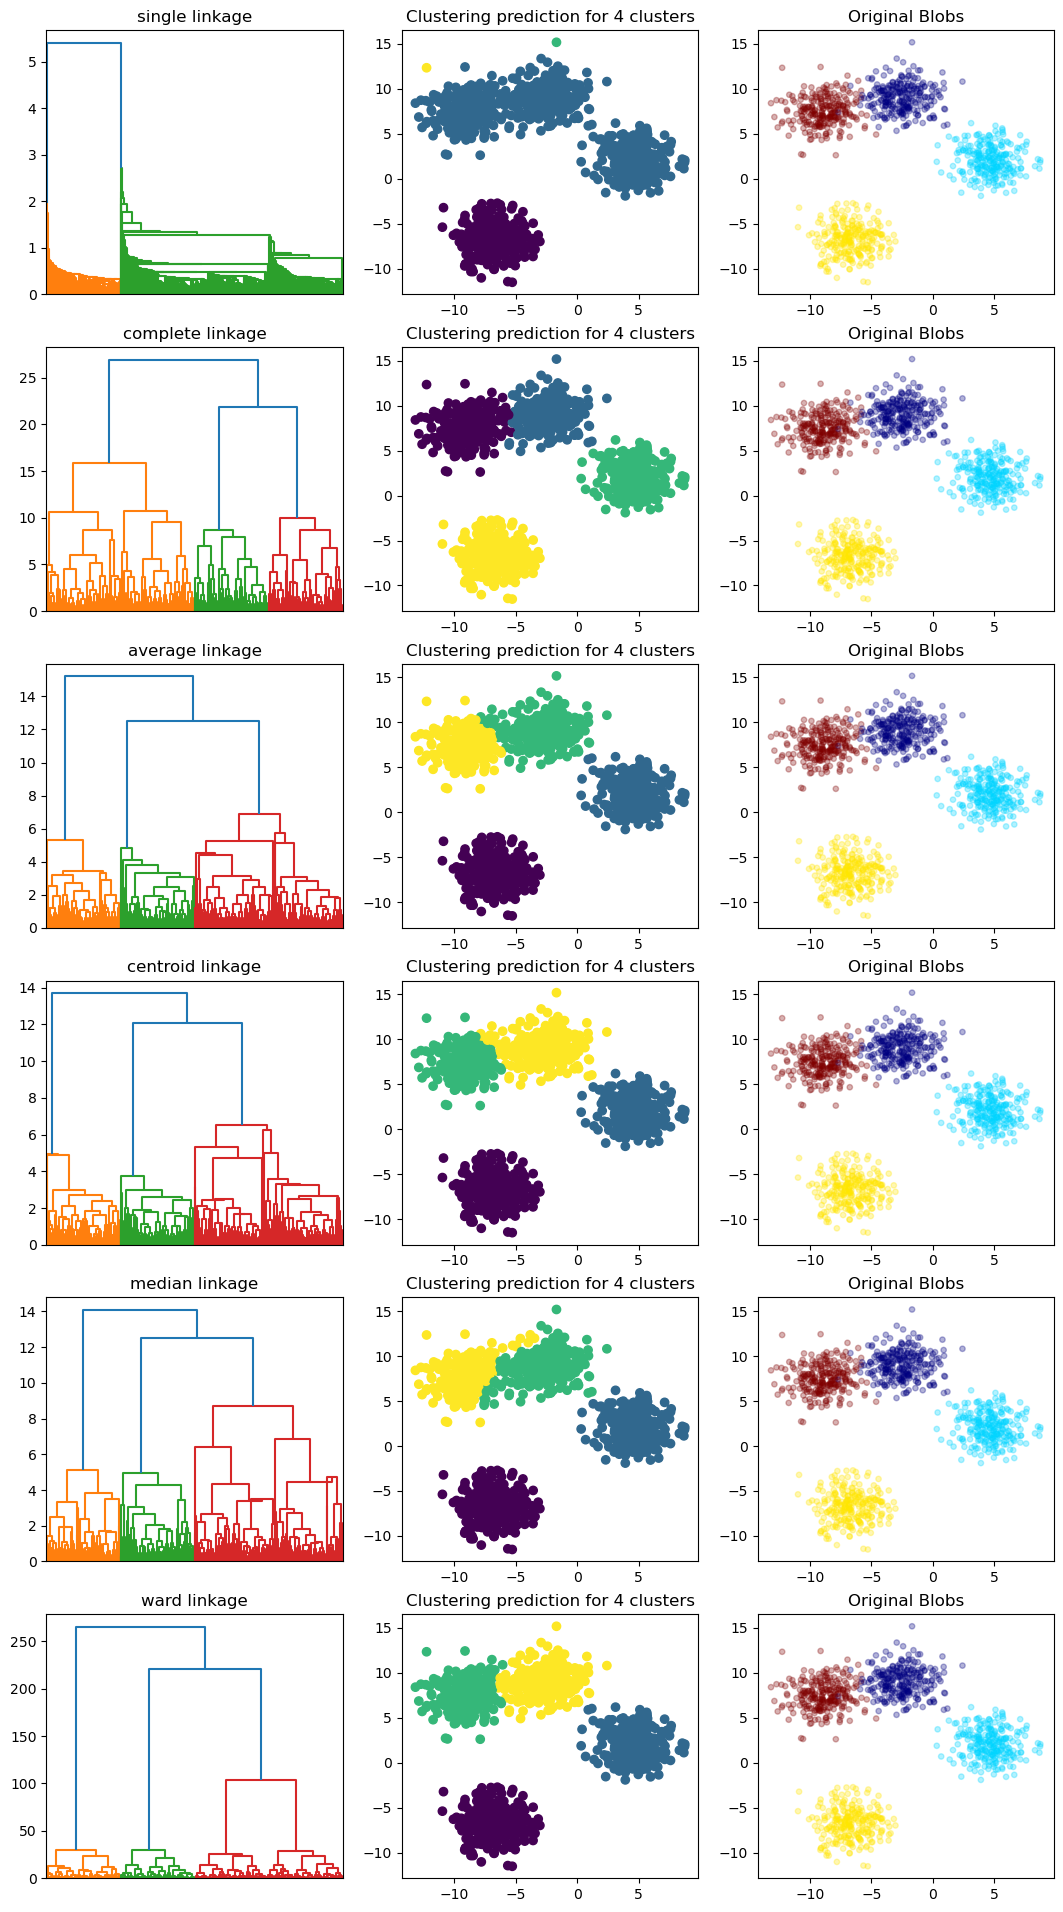

In [68]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Creamos una función para su posterior uso
def dendrograms(X, clusters_num, title):
    plt.figure(figsize=(13,24))
    
    count=1
    for link in linkages:
        # Dendrograma
        Z = linkage(X, method=link)
        plt.subplot(6,3,count)
        plt.title(link+' linkage')
        dendrogram(Z)
        # Ocultamos los xlabels, dado que no aportan información
        plt.setp(plt.gca().get_xticklabels(), visible=False)
        count+=1
        
        # Visualización predicción
        # Obtenemos los datos para crear 't' clusters
        clusters = fcluster(Z, t=clusters_num, criterion='maxclust')
        # Adapto las predicciones para 2 enlaces con el dataset Circles, ya que no detecta correctamente 2 clusters.
        if title == 'Circles' and (link=='median' or link=='centroid'):
            clusters = fcluster(Z, t=clusters_num+1, criterion='maxclust')
        plt.subplot(6,3,count)
        plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='viridis')
        plt.title('Clustering prediction for '+ str(clusters_num) +' clusters')
        count+=1
        
        # Visualización dataset original
        plt.subplot(6,3,count)
        plt.scatter(X[:,0], X[:,1], s=15, c=y, alpha=.3, cmap='jet')
        plt.title("Original " + title) 
        
        count+=1
        
    plt.show()
dendrograms(X, 4, "Blobs")

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> Interpreta el dendrograma y comenta qué criterio de enlace se ha comportado mejor. ¿Por qué?
</div>

El método de single linkage resulta el menos efectivo para el dataset debido a su alta sensibilidad al ruido, lo que puede generar muchos clusters pequeños y un efecto cadena. Al buscar la distancia mínima, se produce una forzada unión de grupos por el hecho de compartir algún elemento muy próximo.

En los plots, se han visualizado las predicciones a 4 clusters con el fin de observar cómo serían dichas agrupaciones, aunque este valor no se suele conocer previamente.

En el caso ideal, buscamos un criterio de enlace que presente pocos clusteres grandes, los enlaces *centroid, median, ward, complete y average* obtienen buenos resultados.
En particular, el enlace **complete** detecta 4 clusters de similar distancia, por lo que parece obtener los mejores resultados.

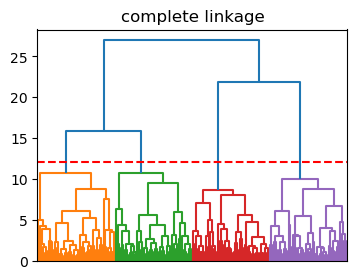

In [70]:
link='complete'
Z = linkage(X, method=link)
plt.figure(figsize=(4, 3))
plt.title(link+' linkage')
dendrogram(Z, color_threshold=12)
# Ocultamos los xlabels, dado que no aportan información
plt.setp(plt.gca().get_xticklabels(), visible=False)
plt.axhline(y=12, color='r', linestyle='--')
plt.show()

In [71]:
X, y = X_moons, y_moons

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
prueba la implementación de <a href="https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html">clustering jerárquico de scipy</a> probando distintos <a href="https://en.wikipedia.org/wiki/Hierarchical_clustering#Linkage_criteria">criterios de enlace o <i>linkage</i></a> permitiendo identificar los clusters subyacentes (mostrando su resultado) y su dendrograma para el dataset Moons.<br>
Puedes importar las librerías necesarias para ello.
</div>

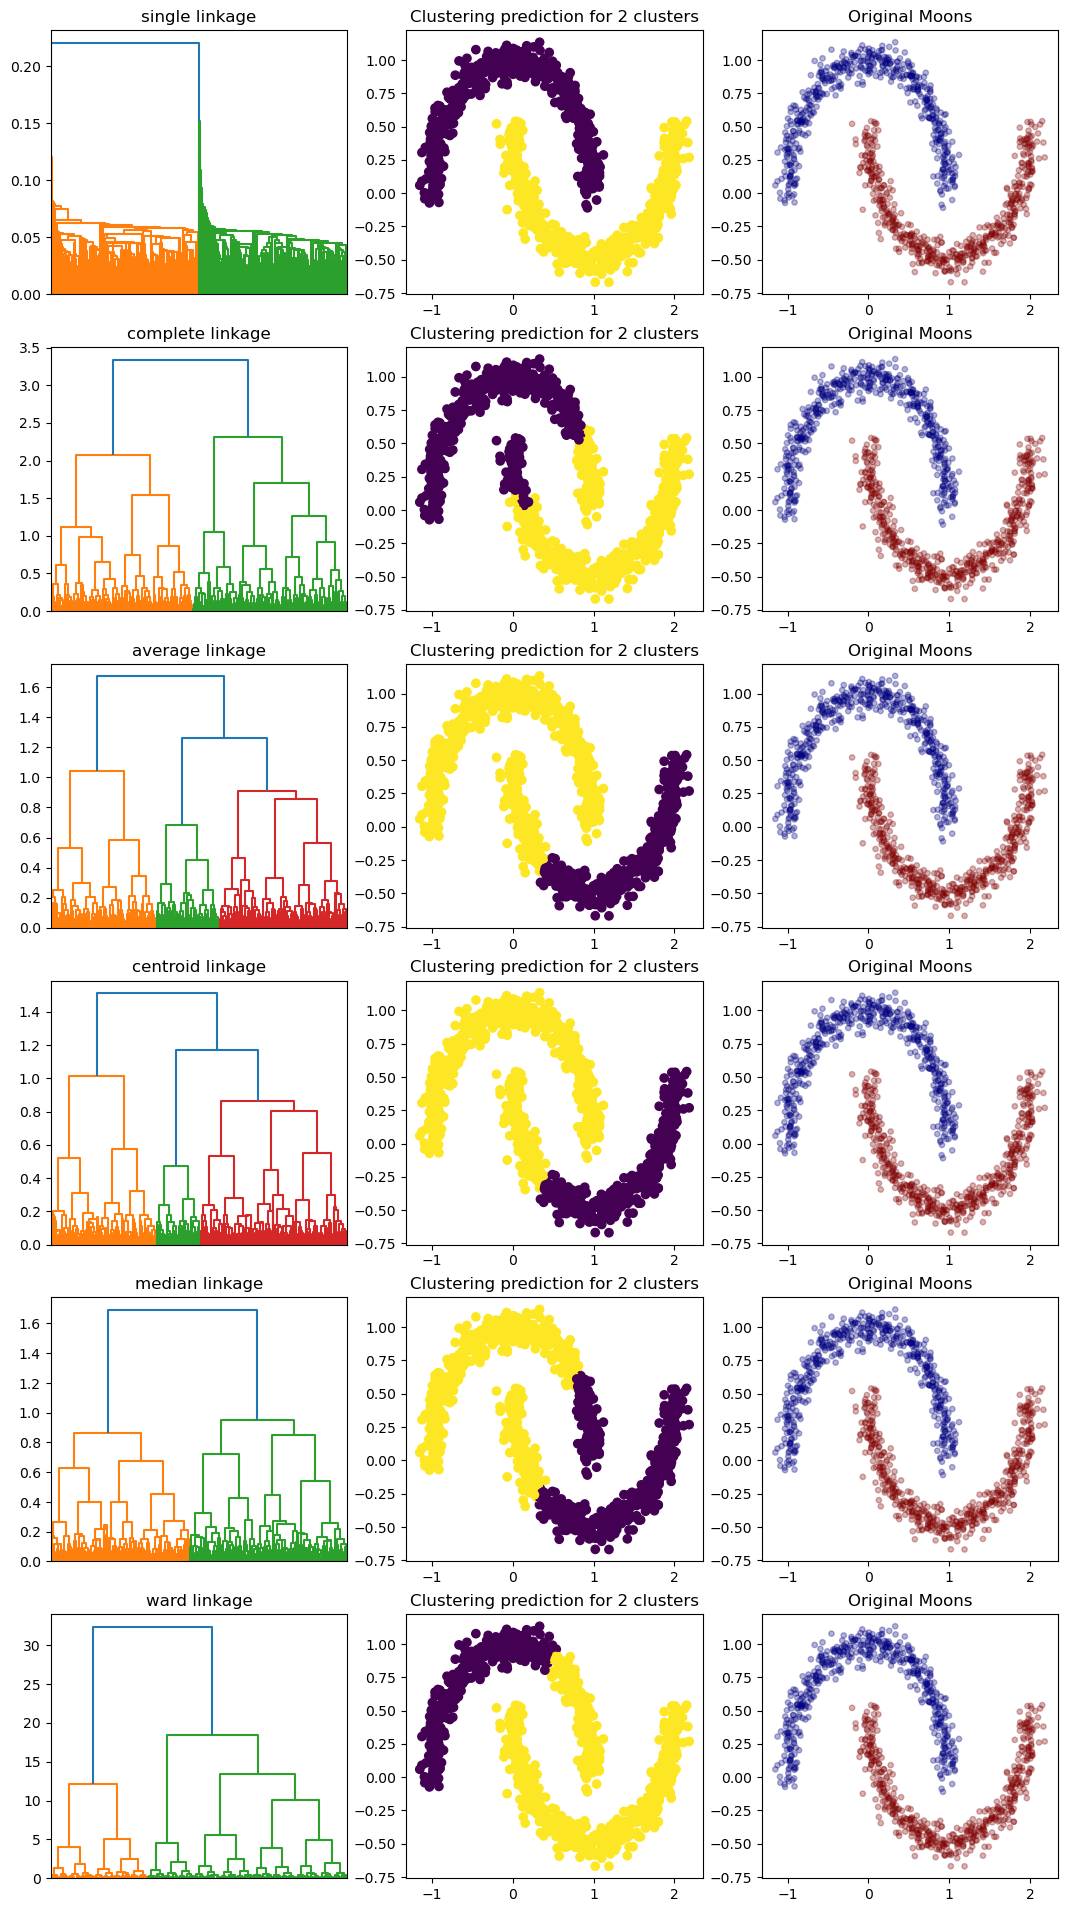

In [301]:
dendrograms(X, 2, 'Moons')

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> Interpreta el dendrograma y comenta qué criterio de enlace se ha comportado mejor. ¿Por qué?
</div>

En comparación con el dataset anterior, **Simple linkage** ha obtenido mejores resultados. Esto se debe a que los clústeres no están tan próximos ni tan dispersos, lo que permite que el método pueda identificar correctamente los clústeres al buscar la distancia mínima.

En cambio, los otros criterios de enlace han detectado los clústeres de forma errónea. Esto se debe a que se basan en valores máximos o medios, lo que no se ajusta bien a la naturaleza de los datos en este caso.

In [72]:
X, y = X_circles, y_circles

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
prueba la implementación de <a href="https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html">clustering jerárquico de scipy</a> probando distintos <a href="https://en.wikipedia.org/wiki/Hierarchical_clustering#Linkage_criteria">criterios de enlace o <i>linkage</i></a> permitiendo identificar los clusters subyacentes (mostrando su resultado) y su dendrograma para el dataset Circles.<br>
Puedes importar las librerías necesarias para ello.
</div>

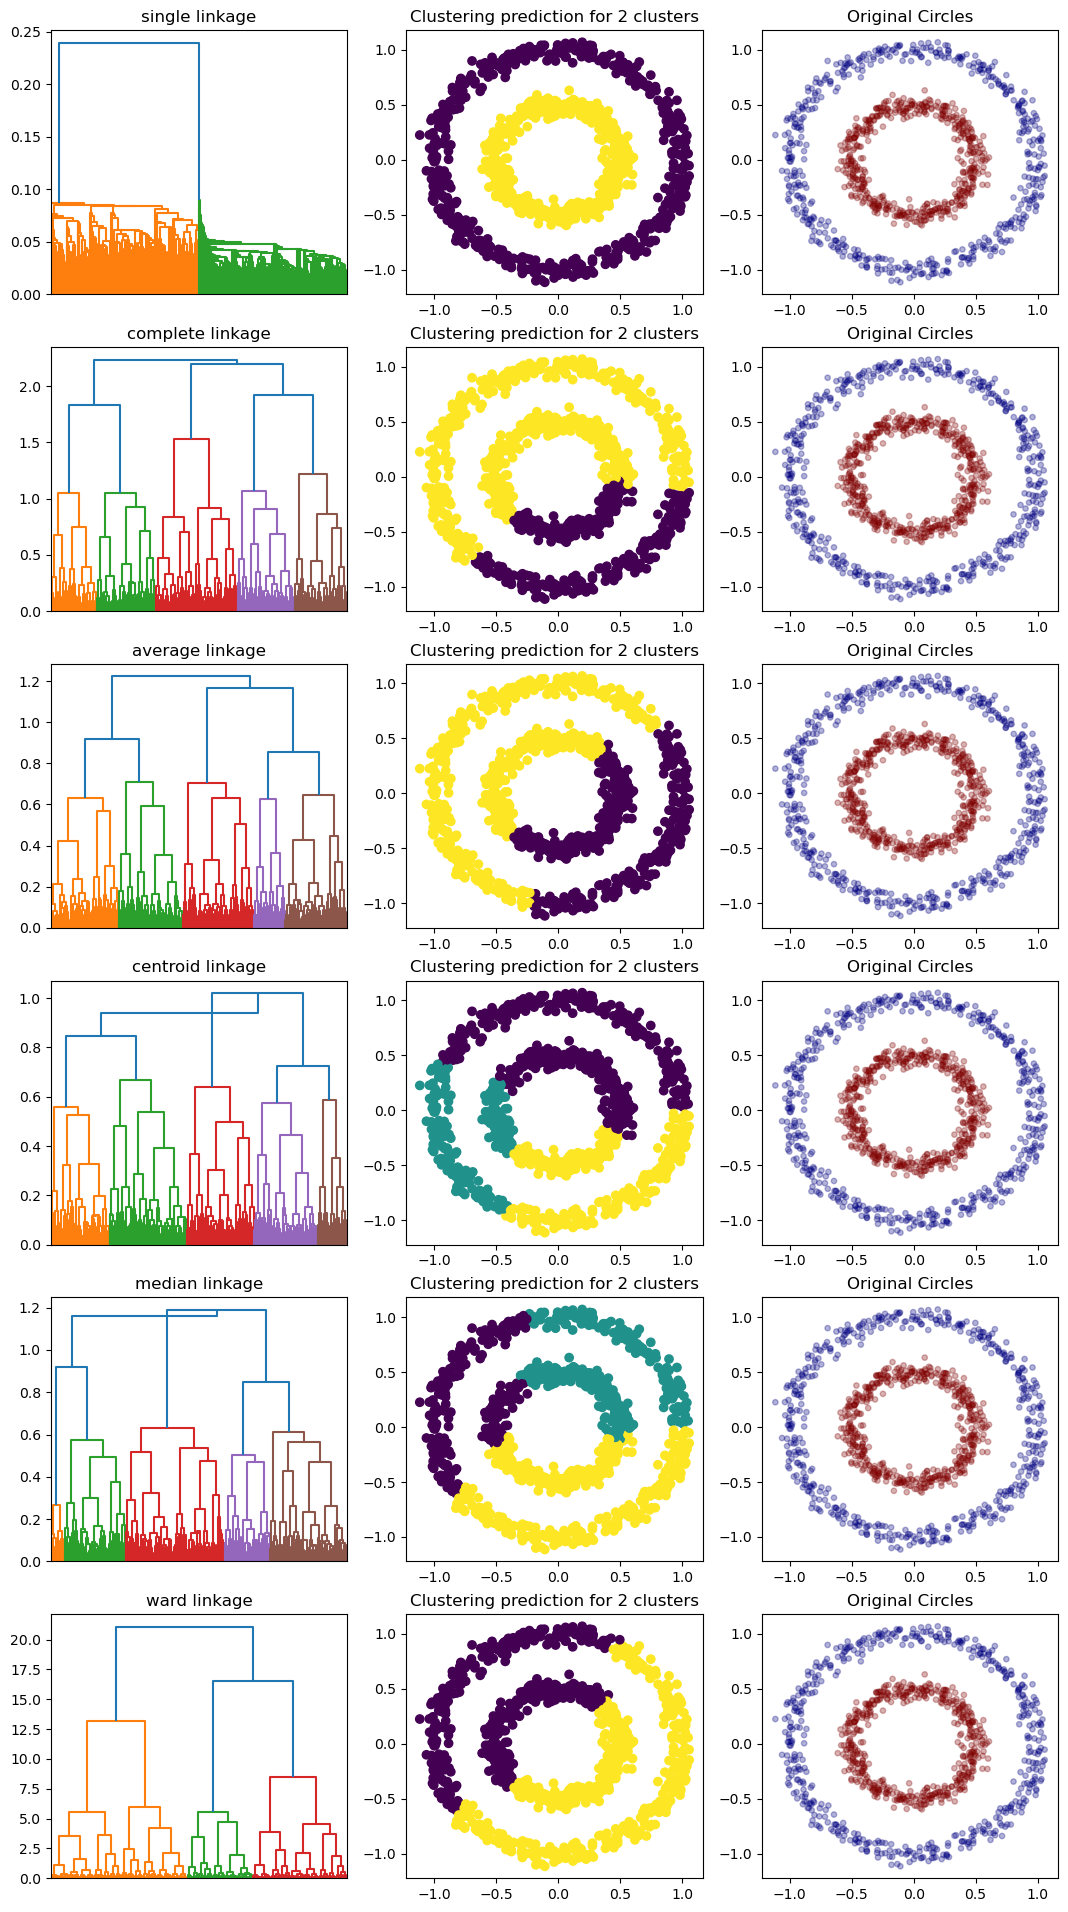

In [303]:
dendrograms(X, 2, 'Circles')

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> Interpreta el dendrograma y comenta qué criterio de enlace se ha comportado mejor. ¿Por qué?
</div>

Similar al dataset anterior, **Simple linkage** es el que performa mejor al buscar la mínima distancia a los vecinos. Dado que existe una separación clara entre las agrupaciones, es capaz de detectar correctamente 2 clusteres.

Para los enlaces *centroid* y *median* han generado una partición inicial en tres clústeres, pero esto no se corresponde con la realidad del dataset y se observa claramente que no es la predicción correcta.

En cuanto a los demás enlaces, también han fallado en detectar correctamente los clústeres en este dataset. En definitiva, *Simple linkage* parece ser la mejor opción para agrupaciones bien delimitadas. Los demás enlaces funcionan mejor para casos en los que los datos de los clústeres estén más próximos o distribuidos.

<a id="ej2"></a>

## 2. Aplicación para comprimir imágenes (3 puntos)

Las imágenes en color se componen de píxeles que tienen tres componentes (roja, azul y verde), destinando 1 *byte* a cada canal. Pudiendo representar $2^8 = 256$ rojos, verdes y azules. Con un total de $2^{8^{3}} = 2^{24} = 16777216$ colores representables en cada píxel.

Entre mayor sea el número de colores representables, más memoria será necesaria para almacenar la imagen.
Por tanto, una estrategia para comprimir una imagen puede ser disminuir los colores representables en cada píxel, necesitando menos *bits* para guardar el valor de un píxel. Este método no es reversible, es decir, no se puede volver a recuperar la imagen original a partir de la comprimida. Por tanto, este tipo de compresiónse denomina [comprensión con pérdidas](https://es.wikipedia.org/wiki/Algoritmo_de_compresi%C3%B3n_con_p%C3%A9rdida).

Pero ¿cómo seleccionamos los "píxeles parecidos" en la imagen original y determinamos su color en la imagen comprimida?. Una opción es utilizar *k-means* donde **$k$ será el número de colores representables**, los puntos que pertenecen a cada cluster equivaldrían a los "píxeles parecidos" y las coordenadas de los **centroides actuarán como los colores finales** a los que se aproximarán los "píxeles parecidos".

Como resultado del clustering, se obtiene una paleta de colores reducida (coordenadas de los centroides) donde cada píxel de la imagen hará referencia a uno de estos colores (cluster al que pertenece). El uso de paletas de colores o [colores indexados](https://en.wikipedia.org/wiki/Indexed_color) es un recurso empleado por distintos formatos de imagen como *PNG*, *GIF* o *TIFF*.

Si no dispones de la librería ``skimage`` puedes instalarla:
 - Usando conda (si has creado tu entorno virtual con conda): ``conda install scikit-image``
 - Usando pip: ``pip install scikit-image``

Imagen con 65536 pixeles (196608 bytes)


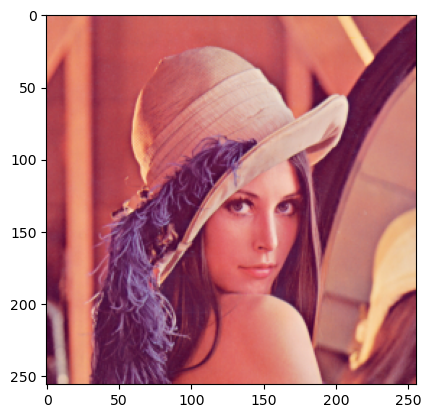

In [304]:
from skimage import io, transform

photo = (transform.resize(
    io.imread('https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png'),
    (256, 256), mode='edge') * 255).astype(np.uint8)
plt.imshow(photo)        # np.array con shape (256, 256, 3), alto por ancho por 3 (los tres canales: rojo, verde y azul), donde cada valor ocupa un byte.
X = photo.reshape(-1, 3) # np.array con shape (65536, 3), cada pixel con sus 3 canales
print('Imagen con {} pixeles ({} bytes)'.format(X.shape[0], X.shape[0] * 3))

Para facilitar la tarea, la imagen anterior está guardada en un *array* con tantas filas como píxeles y columnas como canales (rojo, verde y azul). De forma que cada "muestra" equivale al valor de un píxel.

Se puede volver a recomponer la imagen original con:
```
plt.imshow(X.reshape(photo.shape))
```
Podemos ver cada píxel como un punto en un sistema de coordenadas de 3 dimensiones donde una es su cantidad de rojo, otra su cantidad de verde y por último su cantidad de azul. Por lo que podemos realizar una visualización en 3 dimensiones de los píxeles sobre la que se probará el algoritmo de clustering:

In [305]:
X

array([[225, 136, 125],
       [223, 136, 129],
       [225, 133, 118],
       ...,
       [166,  69,  84],
       [177,  68,  78],
       [182,  72,  80]], dtype=uint8)

Para visualizar la animación de la representación 3D de los píxeles es necesario instalar la librería ``ffmpeg``.

Si tienes un entorno virtual de conda, lo puedes instalar con: ``conda install -c conda-forge ffmpeg``.

**Si tienes un error**, puedes ver una representación estática 2 celdas más adelante.

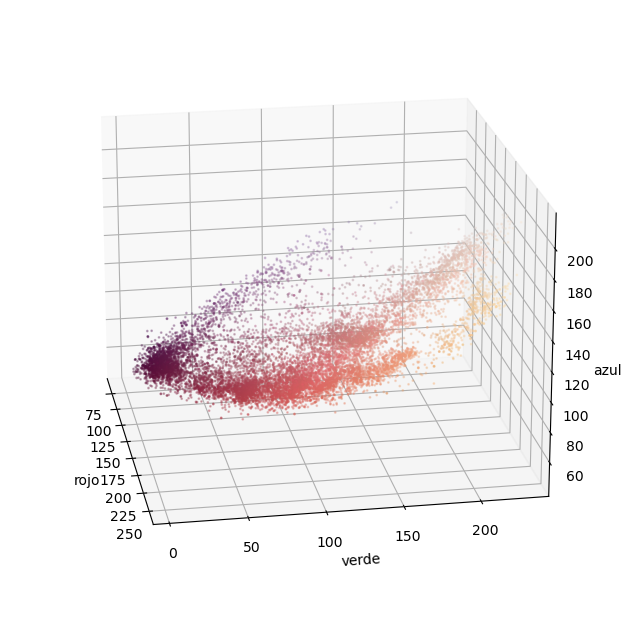

In [28]:
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D

matplotlib.rcParams['animation.html'] = 'html5'

idx = np.random.randint(X.shape[0], size=int(X.shape[0] * .2))
fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig)
ax.scatter(X[idx,0], X[idx,1], X[idx,2], s=1, c=X[idx,:] / 255, alpha=.3)
ax.set_xlabel('rojo')
ax.set_ylabel('verde')
ax.set_zlabel('azul')

def animate(i):
    ax.view_init(elev=20., azim=i)
    return fig,

anim = animation.FuncAnimation(fig, animate, frames=range(0, 360, 10), interval=200, blit=True)
anim

Visualización estática del valor de los píxeles:

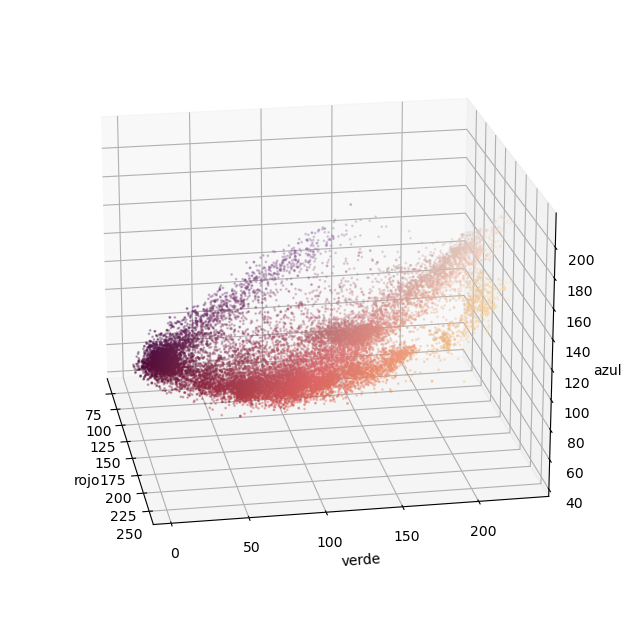

In [29]:
idx = np.random.randint(X.shape[0], size=int(X.shape[0] * .3))
fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig)
ax.scatter(X[idx,0], X[idx,1], X[idx,2], s=1, c=X[idx,:] / 255, alpha=.3)
ax.set_xlabel('rojo')
ax.set_ylabel('verde')
ax.set_zlabel('azul')
ax.view_init(20, 350)
plt.show()

En la visualización anterior se ha representado cada píxel con su color, donde sus coordenadas en los 3 colores oscilan entre 0 (carece de esa componente) y 1. Podemos comprobar como los píxeles en coordenadas (255, 255, 255) son píxeles blancos y los situados en (0, 0, 0) son píxeles negros. También se observan 4 estructuras de píxeles: la pluma del sombrero, el sombrero, la piel de la modelo (Lenna) y el fondo.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> aplicar <i>k-means</i> con <i>k=3</i> a los píxeles de la imagen (puntos con 3 dimensiones de la variable <i>X</i>) y obtener, para cada punto, su centroide más cercano. Y las coordenadas (3 dimensiones) de cada centroide.
</div>

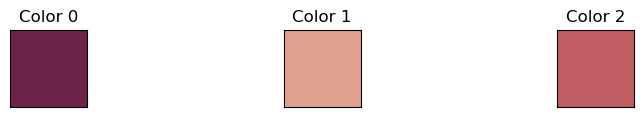

In [369]:
# Al definir 3 clusters, limitamos la imagen a 3 colores RGB
kmeans = cluster.KMeans(n_clusters=3, n_init='auto',random_state=42).fit(X)

# Predecimos a que centroide pertenece cada píxel (a cuál se parece más)
labels = kmeans.predict(X)

# Obtenemos los 3 centroides
centroids = kmeans.cluster_centers_

# Visualizar los 3 colores
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 1))
for i in range(3):
    ax[i].imshow(np.ones((2, 2, 3)) * centroids[i] / 255)
    ax[i].set_title(f'Color {i}')
    ax[i].set_xticks([])
    ax[i].set_yticks([])

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> asgina a cada punto (píxel de la imagen) el valor de su centroide asociado en lugar de su propio valor.
</div>

In [370]:
# Creamos un nuevo array reemplazando cada color por la predicción
X_new = centroids[labels]

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> volver a convertir el resultado en una imagen usando la función <i>reshape</i> (como cuando se creó X) para que vuelva a tener su dimensión de <i>256 x 256</i>. Y mostrarla con <i>imshow</i>.
</div>

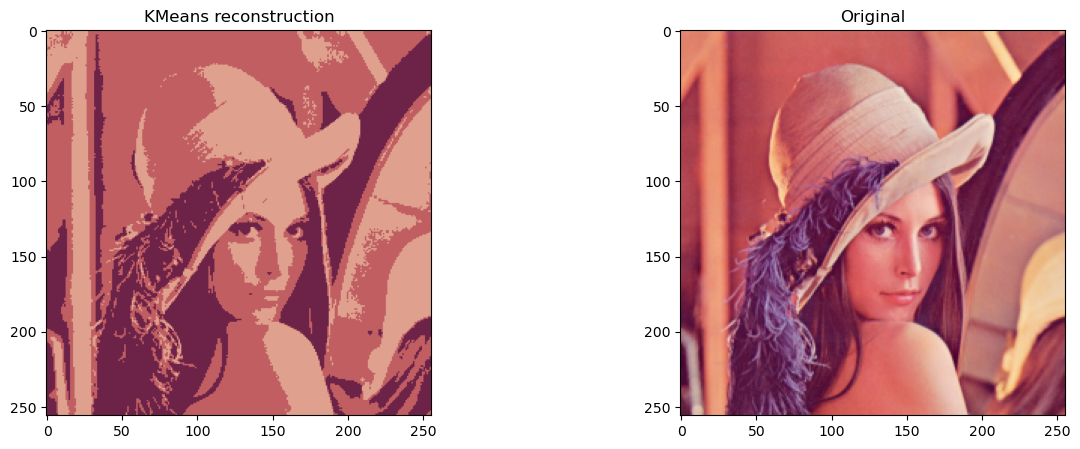

In [386]:
# Mostrar la imagen con los valores de los píxeles reemplazados por los valores de los centroides
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(X_new.reshape(photo.shape)/255.0)
plt.title("KMeans reconstruction")
plt.subplot(122)
plt.imshow(photo)
plt.title("Original")
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿por qué se ha producido este resultado?, ¿qué relación tiene con el clústering?
</div>

Al utilizar KMeans con k=3, hemos buscado 3 centroides de la imagen según los píxeles RGB. 
Hemos reemplazado cada píxel de la imagen original por el centroíde más parecido (distancia color original a color del centroide). Podemos pensar en los píxeles como puntos de datos y los centroides como los representantes de cada cluster.

La relación con clústering está en que en ambos casos agrupamos los datos al clúster más parecido. En el caso de la imagen, estamos agrupando los píxeles en clusters basados en su similitud de color. En el caso de clústering, los puntos se agrupan en clusters basados en su similitud de las características. 

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> realizar el proceso anterior para distintos valores de <i>k</i>: 256, 128, 64, 32, 16, 8, 4 y 2 colores. Mostrar las imágenes e indicar los bytes que ocuparía cada una de las opciones.
</div>

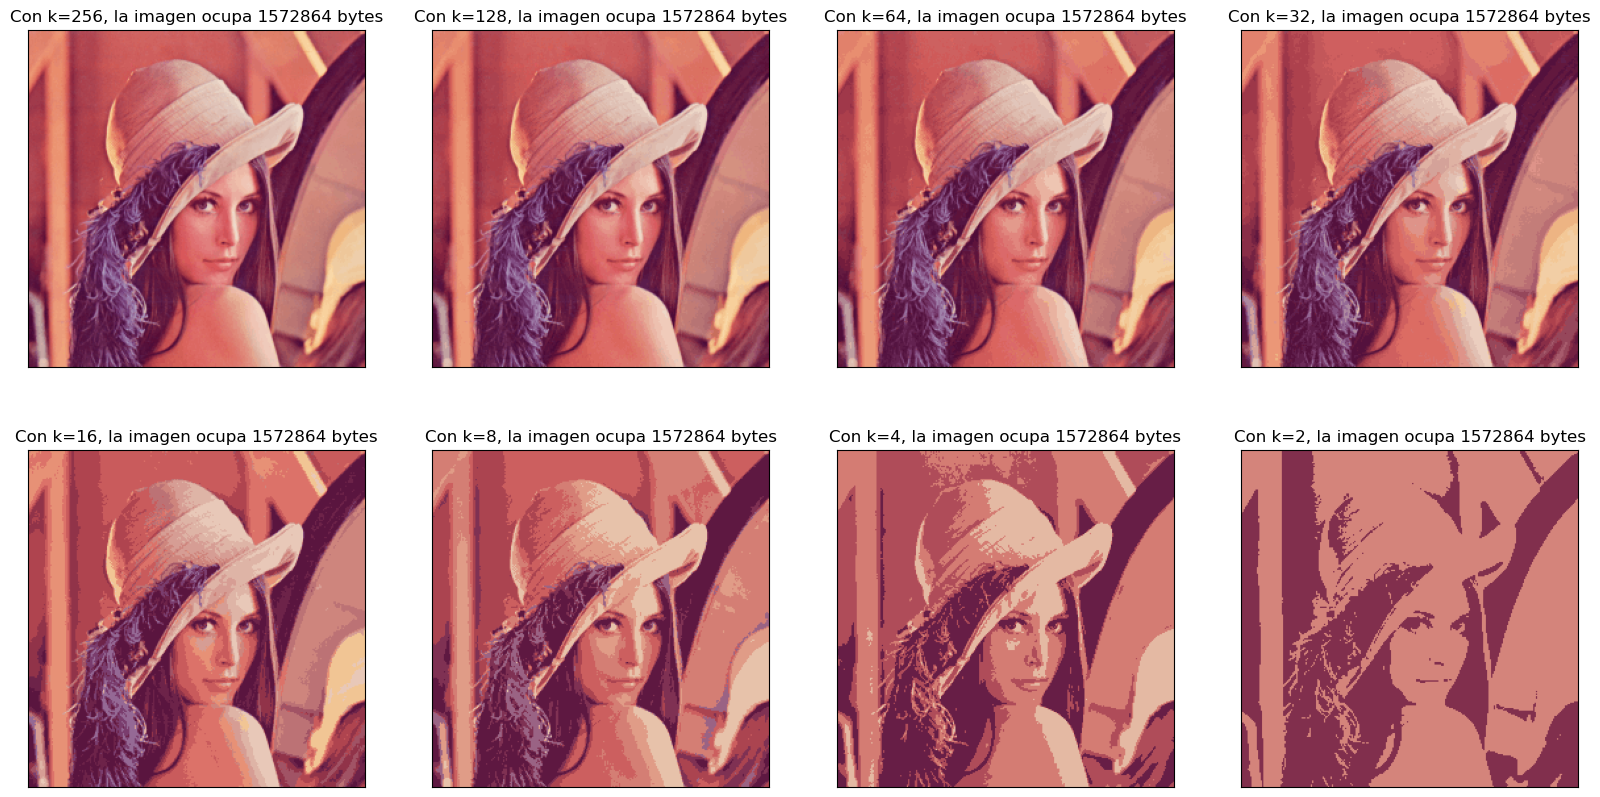

In [479]:
plt.figure(figsize=(20,10))

ks = [256, 128, 64, 32, 16, 8, 4, 2]

# Utilizamos la misma lógica que la anterior implementación
for pos,k in enumerate(ks):
    plt.subplot(2,4,pos+1)
    kmeans = cluster.KMeans(n_clusters=k, n_init='auto',random_state=42).fit(X)
    labels = kmeans.predict(X)
    centroids = kmeans.cluster_centers_
    X_new = centroids[labels]
    plt.imshow(X_new.reshape(photo.shape)/255.0)
    plt.xticks([])
    plt.yticks([])
    # Cantidad de bytes de la imagen
    plt.title(f"Con k={k}, la imagen ocupa {X_new.nbytes} bytes")
plt.show()

<a id="ej3"></a>

## 3. Aplicación de reducción de dimensionalidad para resolver un problema de optimización: t-SNE (2 puntos)

Como ya se ha visto, el algoritmo [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) ideado por [van der Maaten y Hinton](https://lvdmaaten.github.io/tsne/) difiere de PCA en que no trata de maximizar la varianza explicada. Intuitivamente, t-SNE trata de que la vecindad de un punto en baja dimensionalidad sea la misma que la original (mantenga las distancias). Partiendo de una localización aleatoria de cada punto, corrige su posición de forma iterativa tratando de minimizar la distancia a sus vecinos originales hasta converger.

Para ello, t-SNE dispone de diversos [parámetros](https://distill.pub/2016/misread-tsne/) que pueden modificar drásticamente el resultado. Por lo que se recomienda conocer su funcionamiento antes de aplicar la técnica.

Partiendo de las distancias entre las [provincias de España](https://www.gifex.com/images/0X0/2009-12-02-11305/Provincias_de_Espana.jpg), presentes en el fichero de datos (en *pec2_3.p* un *DataFrame* de *pandas* en formato *pickle* o *pec2_3.csv* en formato *CSV*). Se pide calcular la matriz cuadrada que contenga la distancia de cada provincia contra las demás.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> la matriz debe tener tantas filas y columnas como provincias. Y cada celda debe contener la distancia entre las provincias de esa fila y columna.
</div>

In [16]:
# Leemos el fichero
provincias = pd.read_pickle('pec2_3.p')

# Creamos la matriz cuadrada
matriz_distancias = provincias.pivot_table(values='dist', index='from', columns='to').values

# Visualización
pd.DataFrame(matriz_distancias, index=provincias['from'].unique(), columns=provincias['from'].unique()).head()

A Coruña    Albacete  Alicante/Alacant     Almería  \
A Coruña            0.000000  724.856651        846.212163  840.615943   
Albacete          724.856651    0.000000        133.167945  198.373164   
Alicante/Alacant  846.212163  133.167945          0.000000  232.662010   
Almería           840.615943  198.373164        232.662010    0.000000   
Asturias          203.994866  602.411733        708.828268  753.394401   

                    Asturias     Badajoz   Barcelona      Burgos   Cantabria  \
A Coruña          203.994866  532.145376  876.649134  410.217119  367.135855   
Albacete          602.411733  368.490804  456.300748  400.075482  516.518488   
Alicante/Alacant  708.828268  496.514068  407.550071  491.342441  602.775844   
Almería           753.394401  369.104671  632.381406  576.019713  693.069983   
Asturias            0.000000  520.694031  681.616080  229.710582  164.251031   

                  Castellón/Castelló  ...   Tarragona      Teruel      Toledo  \
A Coruña                  762.201706  ...  808.380255  686.035068  502.609834   
Albacete                  202.556989  ...  352.478721  219.562855  230.794941   
Alicante/Alacant          179.985456  ...  315.469036  241.358580  361.648487   
Almería                   384.955553  ...  533.478566  416.103697  344.665423   
Asturias                  596.501705  ...  621.344995  516.468233  410.803414   

                  Valencia/València  Valladolid     Vizcaya      Zamora  \
A Coruña                 788.375067  341.775029  459.120176  265.019803   
Albacete                 126.278287  394.458647  493.407420  460.527619   
Alicante/Alacant          83.901967  508.482111  562.454583  581.223032   
Almería                  289.162304  541.630208  681.728647  588.912271   
Asturias                 640.210776  211.942406  256.054120  181.268009   

                    Zaragoza       Álava       Ávila  
A Coruña          616.475388  473.058961  401.053193  
Albacete          302.157283  436.338317  326.357718  
Alicante/Alacant  343.237317  506.485555  453.163512  
Almería           500.358089  625.207844  446.124144  
Asturias          434.042842  275.452508  314.346015  

[5 rows x 50 columns]

Una vez que se cuenta con la matriz de distancias, *t-SNE* tratará de mantener esas distancias entre los distintos puntos en baja dimensionalidad (en este caso 2 dimensiones). Emplazando los puntos en el plano mientras intenta mantener las distancias indicadas.

Dado que la entrada a [*t-SNE*](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) se le pasa la matriz de distancias, no es necesario que las calcule. Por ello le indicaremos que la métrica a emplear es "precalculada".

Como *t-SNE* es un algoritmo estocástico (dos ejecuciones consecutivas con los mismos datos pueden conducir a resultados diferentes). Se pide realizar el proceso de ajuste con *t-SNE* 100 veces y quedarse con la ejecución con menor error (ver el atributo [*kl_divergence*](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)).

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> jugar con los hiperparámetros de <i>t-SNE</i>, ejecutar 100 veces el ajuste de <i>t-SNE</i> y guardar el resultado de emplazamiento de provincias en el plano de la ejecución con menor error.
</div>

Una vez que se tienen las posiciones de las provincias en el plano, visualizar el resultado y analizar si el emplazamiento de las provincias calculado por *t-SNE* calculado en base a las distancias se parece al real.

In [49]:
from sklearn.manifold import TSNE

# Ejecuto t-SNE 100 veces y guardamos la que proporciona un menor error
best_embedding = None
min_error = float('inf')

# Probamos diferentes parámetros
learning_rates = ['auto'] + [x for x in range(50,300,20)]
n_iters = [1500, 2000]
perplexities = [35,40,45]

for i in range(100):
    learning_rate, n_iter, perplexity = random.choice(learning_rates), random.choice(n_iters), random.choice(perplexities)
    # n_components es el número de dimensiones de los datos.
    tsne = TSNE(init='random', n_components=2, metric='precomputed', learning_rate=learning_rate, n_iter=n_iter, perplexity=perplexity)
    X_tsne = tsne.fit_transform(matriz_distancias)
    error = tsne.kl_divergence_
    if error < min_error:
        best_tsne = X_tsne
        min_error = error
        print(f"Mejor resultado: lr={learning_rate},n_iter={n_iter}, perplexity={perplexity}")

Mejor resultado: lr=190,n_iter=1500, perplexity=35
Mejor resultado: lr=250,n_iter=2000, perplexity=35
Mejor resultado: lr=70,n_iter=1500, perplexity=45
Mejor resultado: lr=70,n_iter=1500, perplexity=45


<div class="alert alert-block alert-info">
<strong>Implementación:</strong> visualizar en un <i>scatter</i> las provincias de la ejecución con menor error, junto con su nombre para poder analizarlo.
</div>

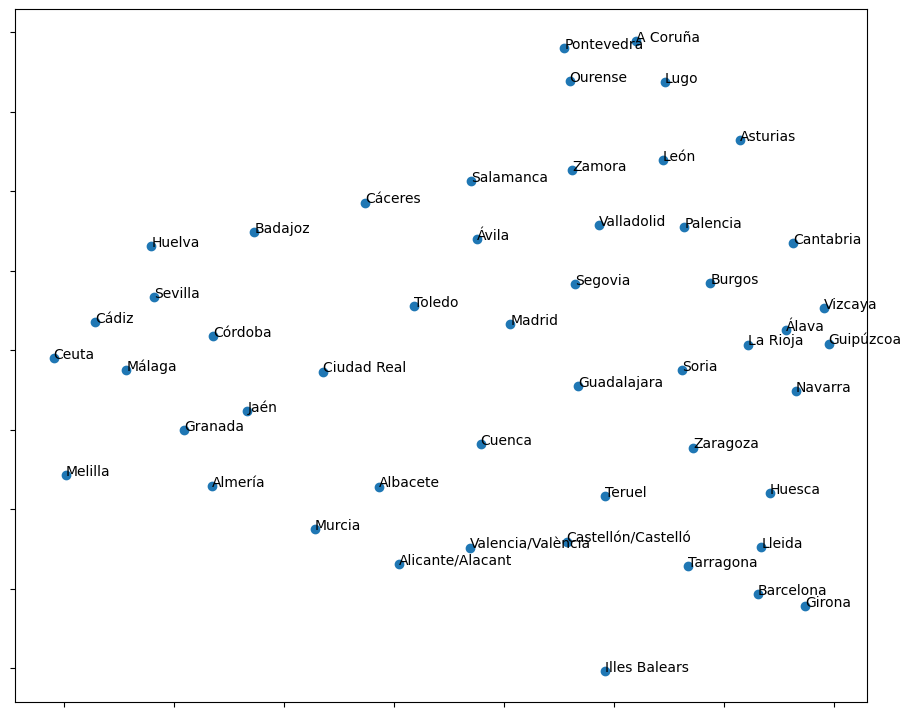

In [73]:
x = best_tsne[:, 0]
y = best_tsne[:, 1]
fig, ax = plt.subplots(figsize=(11,9))
ax.scatter(x, y)
ax.tick_params(labelleft=False)
ax.tick_params(labelbottom=False)
for i, txt in enumerate(provincias['from'].unique()):
    ax.annotate(txt, (x[i], y[i]))
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿se parece a la distribución de provincias real?, ¿por qué?
</div>

La distribución de provincias en el plot se parece a la distribución de provincias real, pero cada provincia parece estar desplazada de su posición original.  Esto se debe a que la información que le proporcionamos a t-SNE es la distancia entre provincias y no su ubicación original, por lo que nunca podría estar cierto sobre la posición inicial de las provincias.

Si giramos el plot 90 grados, podemos obtener una visualización más parecida a la realidad de las provincias de España.

![provincias_España](provincias.png)